# PoC - Ferramenta de processamento

## Avaliação de Ferramentas de Processamento – PoC

Este documento consolida os resultados da PoC realizada para comparar **Pandas, DuckDB, PySpark e Polars**.

---

## Critérios e Pesos

| Critério               | Descrição                                                              |
| ---------------------- | ---------------------------------------------------------------------- |
| Performance            | Tempo de execução em filtros, joins e agregações                       |
| Uso de Recursos        | Consumo de memória e CPU                                               |
| Facilidade de Uso      | Simplicidade da API e curva de aprendizado                             |
| Integração             | Compatibilidade com formatos e ferramentas externas                    |
| Custo / Infraestrutura | Necessidade de recursos adicionais e adequação ao ambiente de produção |

A ferramenta escolhida será aquela que apresentar **maior facilidade de uso**, **melhor performance** e que atenda aos requisitos de **leitura de arquivos CSV** e **escrita em formato Parquet**.



## Preparação dos dados

In [1]:
!pip install pandas duckdb pyspark polars

In [2]:
import duckdb
duckdb.sql('''
INSTALL tpch;
LOAD tpch;
''')
duckdb.sql('''
CALL dbgen(sf = 1);
''')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┐
│ Success │
│ boolean │
├─────────┤
│ 0 rows  │
└─────────┘

In [3]:
def generate_parquet_delta(table):
    duckdb.sql(f"select * from {table}").write_parquet(f'{table}.parquet')


for x in ['nation', 'region', 'customer', 'supplier', 'lineitem', 'orders', 'partsupp', 'part']:
    generate_parquet_delta(x)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

## Performance

Os testes de performance serão realizados utilizando o **TPC-H Benchmark**, com dados gerados via `CALL dbgen(sf=1)`.  

As queries selecionadas serão baseadas no conjunto oficial do TPC-H:  
 [https://www.tpc.org/tpch/](https://www.tpc.org/tpch/)

---

## Setup do Teste
- **Dataset:** TPC-H com Scale Factor de 1 e arquivos Parquet
- **Ferramentas testadas:** Pandas, DuckDB, PySpark, Polars  
- **Métrica principal:** Tempo de execução (segundos)  
- **Hardware:** 12 GB RAM  

---

## Queries Selecionadas
Queries TPC-H para serem utilizadas no benchmark:
- **Q1:** Pricing Summary Report  
- **Q3:** Shipping Priority  
- **Q5:** Local Supplier Volume  
- **Q6:** Forecasting Revenue Change  
- **Q12:** Shipping Modes and Order Priority  


In [4]:
time_data = []

### Pandas

In [5]:
import pandas as pd
import time

# 🔧 Carregando tabelas necessárias (ajuste os paths conforme seu Colab)
lineitem = pd.read_parquet("/content/lineitem.parquet")
orders   = pd.read_parquet("/content/orders.parquet")
customer = pd.read_parquet("/content/customer.parquet")
nation   = pd.read_parquet("/content/nation.parquet")
region   = pd.read_parquet("/content/region.parquet")
supplier = pd.read_parquet("/content/supplier.parquet")

def benchmark(query_name, func):
    start = time.time()
    result = func()
    elapsed = time.time() - start
    print(f"{query_name} executada em {elapsed:.2f}s")
    time_data.append({'tool': 'pandas', 'query': query_name, 'time': elapsed})
    return result


#### Q1 – Pricing Summary Report

SQL Original: agrega lineitem por returnflag e linestatus.

In [6]:
def q1():
    return (
        lineitem
        .assign(l_extendedprice_disc=lambda df: df.l_extendedprice * (1 - df.l_discount))
        .groupby(["l_returnflag", "l_linestatus"], as_index=False)
        .agg(
            sum_qty=("l_quantity", "sum"),
            sum_base_price=("l_extendedprice", "sum"),
            sum_disc_price=("l_extendedprice_disc", "sum"),
            sum_charge=("l_extendedprice", lambda x: (x * (1 - lineitem.l_discount) * (1 + lineitem.l_tax)).sum()),
            avg_qty=("l_quantity", "mean"),
            avg_price=("l_extendedprice", "mean"),
            avg_disc=("l_discount", "mean"),
            count_order=("l_orderkey", "count"),
        )
        .sort_values(["l_returnflag", "l_linestatus"])
    )

q1_result = benchmark("Q1", q1)


Q1 executada em 48.29s


#### Q3 – Shipping Priority

SQL Original: join entre customer, orders, lineitem.

In [7]:
def q3():
    df = (
        customer[customer.c_mktsegment == "BUILDING"]
        .merge(orders, left_on="c_custkey", right_on="o_custkey")
        .merge(lineitem, left_on="o_orderkey", right_on="l_orderkey")
    )
    return (
        df[(df.o_orderdate < pd.Timestamp("1995-03-15").date()) & (df.l_shipdate > pd.Timestamp("1995-03-15").date())]
        .assign(revenue=lambda x: x.l_extendedprice * (1 - x.l_discount))
        .groupby(["l_orderkey", "o_orderdate", "o_shippriority"], as_index=False)
        .agg(revenue=("revenue", "sum"))
        .sort_values(["revenue", "o_orderdate"], ascending=[False, True])
        .head(10)
    )

q3_result = benchmark("Q3", q3)


Q3 executada em 4.54s


#### Q5 – Local Supplier Volume

In [8]:
def q5():
    df = (
        region[region.r_name == "ASIA"]
        .merge(nation, left_on="r_regionkey", right_on="n_regionkey")
        .merge(customer, left_on="n_nationkey", right_on="c_nationkey")
        .merge(orders, left_on="c_custkey", right_on="o_custkey")
        .merge(lineitem, left_on="o_orderkey", right_on="l_orderkey")
        .merge(supplier, left_on="l_suppkey", right_on="s_suppkey")
        .merge(nation, left_on="s_nationkey", right_on="n_nationkey", suffixes=("", "_supp"))
    )
    return (
        df[(df.o_orderdate >=  pd.Timestamp("1994-01-01").date()) & (df.o_orderdate < pd.Timestamp("1995-01-01").date())]
        .assign(revenue=lambda x: x.l_extendedprice * (1 - x.l_discount))
        .groupby("n_name_supp", as_index=False)
        .agg(revenue=("revenue", "sum"))
        .sort_values("revenue", ascending=False)
    )

q5_result = benchmark("Q5", q5)


Q5 executada em 12.87s


#### Q6 – Forecasting Revenue Change

In [9]:
def q6():
    return (
        lineitem[
            (lineitem.l_shipdate >= pd.Timestamp("1994-01-01").date()) &
            (lineitem.l_shipdate < pd.Timestamp("1995-01-01").date()) &
            (lineitem.l_discount.between(0.05, 0.07)) &
            (lineitem.l_quantity < 24)
        ]
        .assign(revenue=lambda x: x.l_extendedprice * x.l_discount)
        .agg(revenue=("revenue", "sum"))
    )

q6_result = benchmark("Q6", q6)


Q6 executada em 13.44s


#### Q12 – Shipping Modes and Order Priority

In [10]:
def q12():
    df = (
        orders
        .merge(lineitem, left_on="o_orderkey", right_on="l_orderkey")
    )
    filtered = df[
        (df.l_shipmode.isin(["MAIL", "SHIP"])) &
        (df.l_commitdate < df.l_receiptdate) &
        (df.l_shipdate < df.l_commitdate) &
        (df.l_receiptdate >= pd.Timestamp("1995-01-01").date()) &
        (df.l_receiptdate < pd.Timestamp("1995-01-01").date())
    ]
    high = ((filtered.o_orderpriority == "1-URGENT") | (filtered.o_orderpriority == "2-HIGH")).astype(int)
    low = (~((filtered.o_orderpriority == "1-URGENT") | (filtered.o_orderpriority == "2-HIGH"))).astype(int)

    return (
        filtered
        .groupby("l_shipmode", as_index=False)
        .agg(high_line_count=("o_orderpriority", lambda _: high.sum()),
             low_line_count=("o_orderpriority", lambda _: low.sum()))
        .sort_values("l_shipmode")
    )

q12_result = benchmark("Q12", q12)


Q12 executada em 5.65s


### DuckDB

In [11]:
import duckdb
import time
con = duckdb.connect(database=':memory:')


def benchmark(query_name, sql):
    start = time.time()
    result = con.execute(sql).df()
    elapsed = time.time() - start
    time_data.append({'tool': 'duckdb', 'query': query_name, 'time': elapsed})
    print(f"{query_name} executada em {elapsed:.2f}s")
    return result

#### Q1 – Pricing Summary Report

In [12]:
q1_sql = """
SELECT
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM lineitem.parquet
WHERE l_shipdate <= DATE '1998-12-01' - INTERVAL '90' DAY
GROUP BY l_returnflag, l_linestatus
ORDER BY l_returnflag, l_linestatus;
"""

q1_result = benchmark("Q1", q1_sql)


Q1 executada em 1.03s


#### Q3 – Shipping Priority

In [13]:
q3_sql = """
SELECT
    l_orderkey,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    o_orderdate,
    o_shippriority
FROM customer.parquet, orders.parquet, lineitem.parquet
WHERE c_mktsegment = 'BUILDING'
  AND c_custkey = o_custkey
  AND l_orderkey = o_orderkey
  AND o_orderdate < DATE '1995-03-15'
  AND l_shipdate > DATE '1995-03-15'
GROUP BY l_orderkey, o_orderdate, o_shippriority
ORDER BY revenue DESC, o_orderdate
LIMIT 10;
"""

q3_result = benchmark("Q3", q3_sql)


Q3 executada em 0.49s


#### Q5 – Local Supplier Volume

In [14]:
q5_sql = """
SELECT
    n_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM customer.parquet, orders.parquet, lineitem.parquet, supplier.parquet, nation.parquet, region.parquet
WHERE c_custkey = o_custkey
  AND l_orderkey = o_orderkey
  AND l_suppkey = s_suppkey
  AND c_nationkey = s_nationkey
  AND s_nationkey = n_nationkey
  AND n_regionkey = r_regionkey
  AND r_name = 'ASIA'
  AND o_orderdate >= DATE '1994-01-01'
  AND o_orderdate < DATE '1995-01-01'
GROUP BY n_name
ORDER BY revenue DESC;
"""

q5_result = benchmark("Q5", q5_sql)


Q5 executada em 0.42s


#### Q6 – Forecasting Revenue Change

In [15]:
q6_sql = """
SELECT
    SUM(l_extendedprice * l_discount) AS revenue
FROM lineitem.parquet
WHERE l_shipdate >= DATE '1994-01-01'
  AND l_shipdate < DATE '1995-01-01'
  AND l_discount BETWEEN 0.05 AND 0.07
  AND l_quantity < 24;
"""

q6_result = benchmark("Q6", q6_sql)


Q6 executada em 0.17s


#### Q12 – Shipping Modes and Order Priority

In [16]:
q12_sql = """
SELECT
    l_shipmode,
    SUM(CASE WHEN o_orderpriority = '1-URGENT' OR o_orderpriority = '2-HIGH'
             THEN 1 ELSE 0 END) AS high_line_count,
    SUM(CASE WHEN o_orderpriority <> '1-URGENT' AND o_orderpriority <> '2-HIGH'
             THEN 1 ELSE 0 END) AS low_line_count
FROM orders.parquet, lineitem.parquet
WHERE o_orderkey = l_orderkey
  AND l_shipmode IN ('MAIL', 'SHIP')
  AND l_commitdate < l_receiptdate
  AND l_shipdate < l_commitdate
  AND l_receiptdate >= DATE '1994-01-01'
  AND l_receiptdate < DATE '1995-01-01'
GROUP BY l_shipmode
ORDER BY l_shipmode;
"""

q12_result = benchmark("Q12", q12_sql)


Q12 executada em 0.23s


### PySpark

In [17]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.read.parquet('lineitem.parquet').createOrReplaceTempView("lineitem")
spark.read.parquet('orders.parquet').createOrReplaceTempView("orders")
spark.read.parquet('nation.parquet').createOrReplaceTempView("nation")
spark.read.parquet('customer.parquet').createOrReplaceTempView("customer")
spark.read.parquet('partsupp.parquet').createOrReplaceTempView("partsupp")
spark.read.parquet('supplier.parquet').createOrReplaceTempView("supplier")
spark.read.parquet('region.parquet').createOrReplaceTempView("region")
spark.read.parquet('part.parquet').createOrReplaceTempView("part")

In [18]:
def benchmark(query_name, sql):
    start = time.time()
    result = spark.sql(sql).count()
    elapsed = time.time() - start
    time_data.append({'tool': 'spark', 'query': query_name, 'time': elapsed})
    print(f"{query_name} executada em {elapsed:.2f}s")
    return result

#### Q1 – Pricing Summary Report

In [19]:
q1_sql = '''
SELECT
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;
'''
q1_result = benchmark("Q1", q1_sql)


Q1 executada em 8.48s


#### Q3 – Shipping Priority

In [20]:
q3_sql = '''
SELECT
    l_orderkey,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    o_orderdate,
    o_shippriority
FROM
    customer,
    orders,
    lineitem
WHERE
    c_mktsegment = 'BUILDING'
    AND c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate < CAST('1995-03-15' AS date)
    AND l_shipdate > CAST('1995-03-15' AS date)
GROUP BY
    l_orderkey,
    o_orderdate,
    o_shippriority
ORDER BY
    revenue DESC,
    o_orderdate
'''
q3_result = benchmark("Q3", q3_sql)


Q3 executada em 8.34s


#### Q5 – Local Supplier Volume

In [21]:
q5_sql = '''
SELECT
    n_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    customer,
    orders,
    lineitem,
    supplier,
    nation,
    region
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND l_suppkey = s_suppkey
    AND c_nationkey = s_nationkey
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'ASIA'
    AND o_orderdate >= CAST('1994-01-01' AS date)
    AND o_orderdate < CAST('1995-01-01' AS date)
GROUP BY
    n_name
ORDER BY
    revenue DESC;
'''
q5_result = benchmark("Q5", q5_sql)


Q5 executada em 9.16s


#### Q6 – Forecasting Revenue Change

In [22]:
q6_sql = '''
SELECT
    SUM(l_extendedprice * l_discount) AS revenue
FROM
    lineitem
WHERE
    l_shipdate >= CAST('1994-01-01' AS date)
    AND l_shipdate < CAST('1995-01-01' AS date)
    AND l_discount BETWEEN 0.05
    AND 0.07
    AND l_quantity < 24;
'''
q6_result = benchmark("Q6", q6_sql)


Q6 executada em 1.58s


#### Q12 – Shipping Modes and Order Priority

In [23]:
q12_sql = '''
SELECT
    l_shipmode,
    SUM(
        CASE
            WHEN o_orderpriority = '1-URGENT'
            OR o_orderpriority = '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS high_line_count,
    SUM(
        CASE
            WHEN o_orderpriority <> '1-URGENT'
            AND o_orderpriority <> '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS low_line_count
FROM
    orders,
    lineitem
WHERE
    o_orderkey = l_orderkey
    AND l_shipmode IN ('MAIL', 'SHIP')
    AND l_commitdate < l_receiptdate
    AND l_shipdate < l_commitdate
    AND l_receiptdate >= CAST('1994-01-01' AS date)
    AND l_receiptdate < CAST('1995-01-01' AS date)
GROUP BY
    l_shipmode
ORDER BY
    l_shipmode;
'''
q12_result = benchmark("Q12", q12_sql)


Q12 executada em 6.26s


### Polars

In [24]:
import polars as pl
import time

# 🔧 Carregar tabelas (Parquet)
lineitem = pl.read_parquet("/content/lineitem.parquet")
orders   = pl.read_parquet("/content/orders.parquet")
customer = pl.read_parquet("/content/customer.parquet")
nation   = pl.read_parquet("/content/nation.parquet")
region   = pl.read_parquet("/content/region.parquet")
supplier = pl.read_parquet("/content/supplier.parquet")

def benchmark(query_name, func):
    start = time.time()
    result = func()
    elapsed = time.time() - start
    time_data.append({'tool': 'polars', 'query': query_name, 'time': elapsed})
    print(f"{query_name} executada em {elapsed:.2f}s")
    return result


#### Q1 – Pricing Summary Report

In [25]:
from datetime import date

def q1():
    var1 = date(1998, 9, 2)

    return (
        lineitem.filter(pl.col("l_shipdate") <= var1)
        .group_by("l_returnflag", "l_linestatus")
        .agg(
            pl.sum("l_quantity").alias("sum_qty"),
            pl.sum("l_extendedprice").alias("sum_base_price"),
            (pl.col("l_extendedprice") * (1.0 - pl.col("l_discount")))
            .sum()
            .alias("sum_disc_price"),
            (
                pl.col("l_extendedprice")
                * (1.0 - pl.col("l_discount"))
                * (1.0 + pl.col("l_tax"))
            )
            .sum()
            .alias("sum_charge"),
            pl.mean("l_quantity").alias("avg_qty"),
            pl.mean("l_extendedprice").alias("avg_price"),
            pl.mean("l_discount").alias("avg_disc"),
            pl.len().alias("count_order"),
        )
        .sort("l_returnflag", "l_linestatus")
    )

q1_result = benchmark("Q1", q1)


Q1 executada em 1.86s


#### Q3 – Shipping Priority

In [26]:
def q3():
    var1 = "BUILDING"
    var2 = date(1995, 3, 15)

    return (
        customer.filter(pl.col("c_mktsegment") == var1)
        .join(orders, left_on="c_custkey", right_on="o_custkey")
        .join(lineitem, left_on="o_orderkey", right_on="l_orderkey")
        .filter(pl.col("o_orderdate") < var2)
        .filter(pl.col("l_shipdate") > var2)
        .with_columns(
            (pl.col("l_extendedprice") * (1 - pl.col("l_discount"))).alias("revenue")
        )
        .group_by("o_orderkey", "o_orderdate", "o_shippriority")
        .agg(pl.sum("revenue"))
        .select(
            pl.col("o_orderkey").alias("l_orderkey"),
            "revenue",
            "o_orderdate",
            "o_shippriority",
        )
        .sort(by=["revenue", "o_orderdate"], descending=[True, False])
        .head(10)
    )

q3_result = benchmark("Q3", q3)


Q3 executada em 1.54s


#### Q5 – Local Supplier Volume

In [27]:
def q5():
    var1 = "ASIA"
    var2 = date(1994, 1, 1)
    var3 = date(1995, 1, 1)

    return (
        region.join(nation, left_on="r_regionkey", right_on="n_regionkey")
        .join(customer, left_on="n_nationkey", right_on="c_nationkey")
        .join(orders, left_on="c_custkey", right_on="o_custkey")
        .join(lineitem, left_on="o_orderkey", right_on="l_orderkey")
        .join(
            supplier,
            left_on=["l_suppkey", "n_nationkey"],
            right_on=["s_suppkey", "s_nationkey"],
        )
        .filter(pl.col("r_name") == var1)
        .filter(pl.col("o_orderdate").is_between(var2, var3, closed="left"))
        .with_columns(
            (pl.col("l_extendedprice") * (1 - pl.col("l_discount"))).alias("revenue")
        )
        .group_by("n_name")
        .agg(pl.sum("revenue"))
        .sort(by="revenue", descending=True)
    )

q5_result = benchmark("Q5", q5)


Q5 executada em 3.86s


#### Q6 – Forecasting Revenue Change

In [28]:
def q6():
    var1 = date(1994, 1, 1)
    var2 = date(1995, 1, 1)
    var3 = 0.05
    var4 = 0.07
    var5 = 24

    return (
        lineitem.filter(pl.col("l_shipdate").is_between(var1, var2, closed="left"))
        .filter(pl.col("l_discount").is_between(var3, var4))
        .filter(pl.col("l_quantity") < var5)
        .with_columns(
            (pl.col("l_extendedprice") * pl.col("l_discount")).alias("revenue")
        )
        .select(pl.sum("revenue"))
    )

q6_result = benchmark("Q6", q6)


Q6 executada em 0.16s


#### Q12 – Shipping Modes and Order Priority

In [29]:
def q12():
    var1 = "MAIL"
    var2 = "SHIP"
    var3 = date(1994, 1, 1)
    var4 = date(1995, 1, 1)

    return (
        orders.join(lineitem, left_on="o_orderkey", right_on="l_orderkey")
        .filter(pl.col("l_shipmode").is_in([var1, var2]))
        .filter(pl.col("l_commitdate") < pl.col("l_receiptdate"))
        .filter(pl.col("l_shipdate") < pl.col("l_commitdate"))
        .filter(pl.col("l_receiptdate").is_between(var3, var4, closed="left"))
        .with_columns(
            line_count=pl.col("o_orderpriority").is_in(["1-URGENT", "2-HIGH"])
        )
        .group_by("l_shipmode")
        .agg(
            high_line_count=pl.col.line_count.sum(),
            low_line_count=pl.col.line_count.not_().sum(),
        )
        .sort("l_shipmode")
    )

q12_result = benchmark("Q12", q12)


Q12 executada em 2.44s


## Resultados

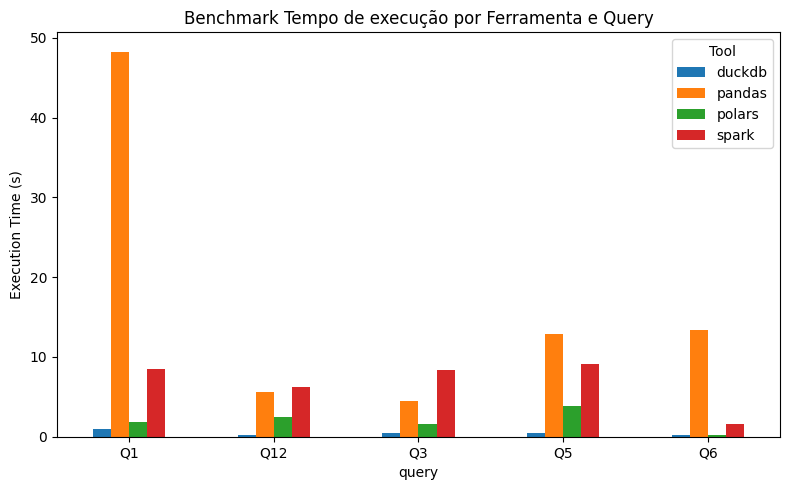

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(time_data)

pivot_df = df.pivot(index="query", columns="tool", values="time")

pivot_df.plot(kind="bar", figsize=(8, 5))

plt.ylabel("Execution Time (s)")
plt.title("Benchmark Tempo de execução por Ferramenta e Query")
plt.xticks(rotation=0)
plt.legend(title="Tool")
plt.tight_layout()
plt.show()


## Resultados de Performance


**Observações:**
- **DuckDB** apresentou tempos consistentes e muito baixos em todas as queries.  
- **Polars** teve performance próxima ao DuckDB, com pequenas variações em agregações mais complexas.  
- **Pandas** apresentou maior tempo de execução, especialmente em **Q1**.  
- **PySpark** teve desempenho razoável, mas com overhead perceptível para dataset pequeno (SF=1).  


**Análise dos Critérios**
| Critério                   | Avaliação Comparativa                                                                                                                                                                                                                                       |
| -------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Performance**            | DuckDB e Polars foram os mais rápidos e consistentes. Pandas teve tempo muito alto (especialmente Q1). PySpark ficou intermediário, mas com overhead para dataset pequeno.                                                                                  |
| **Uso de Recursos**        | Pandas consome bastante memória em joins/aggregações. PySpark exige overhead de cluster/executores mesmo em SF=1. DuckDB e Polars são mais eficientes em memória e CPU.                                                                                     |
| **Facilidade de Uso**      | Pandas tem a curva de aprendizado mais baixa (muito difundido). Polars é bastante simples e tem API parecida com Pandas. DuckDB requer SQL (curva menor para quem já sabe SQL). PySpark exige mais configuração e código.                                   |
| **Integração**             | Pandas lê bem CSV/Parquet, mas não escala. Polars suporta bem CSV, Parquet e Arrow. DuckDB integra facilmente com Parquet, Arrow, Pandas e até dados remotos. PySpark tem a maior flexibilidade em integrações (S3, Hive, Delta, etc.), mas com mais setup. |
| **Custo / Infraestrutura** | Pandas, Polars e DuckDB rodam localmente sem necessidade de cluster. PySpark exige mais infraestrutura (mesmo em modo local, há overhead).                                                   |


## Conclusão

- Para cenários **em single-node e datasets até escala moderada**, **DuckDB** e **Polars** se mostraram as melhores opções, conciliando **performance, baixo uso de recursos e facilidade de integração com CSV/Parquet**.  
- **Pandas** continua útil para prototipação, mas não escalou bem neste benchmark.  
- **PySpark** é mais adequado para cenários **distribuídos e de grande escala**, mas não se destacou no dataset pequeno utilizado.  

**Ferramentas escolhida:** **DuckDB**